In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os

#Import Custom Classes

from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas

In [3]:
#Hyper-parameters
BUFFER_SIZE = int(1e5)      #replay buffer size
BATCH_SIZE = 128             #minibatch size
GAMMA = 0.999                #discount factor
TAU = 1e-3                  #for soft update of target parameters
LR = 5e-4                   #learning rate
UPDATE_EVERY = 50            #how often to update the network
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.997#0.9983 #125e-6
train_episodes = 1600
test_episodes = 1
seed = 0                    #random seed number
episode_step_limit = 50
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
#Choose the environment
em = EnvManager(device, 'combrfinit-v2', seed)
available_actions = em.num_actions_available()
random.seed(seed)
state_size = em.state_size()

#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=4, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=64, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=64, out_features=8, bias=True)
)


## Test with random untrained actions

In [5]:
obs = em.env.reset()
print(obs)
ep_rwd=[]
while True:
    action = random.randrange(em.env.action_space.n)
    
    obs, rwd, done, _ = em.env.step(action)
    print(action)
    ep_rwd.append(rwd)
    if done:
        break
        
print("Episode score: {}".format(np.sum(ep_rwd)))

[[0.0101453 0.5       0.2       0.       ]]
6
6
0
4
7
6
4
7
Episode score: -1.0


## Train the DQN agent

c:\pycharm_workspace\precoding_rl\venv\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


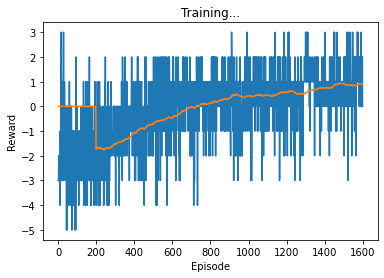

In [6]:
ep_rewards = []
policy_net.train()

outer = tqdm.tqdm_notebook(total=train_episodes, desc='training loop: ', position=0)

for episode in range(train_episodes):
    obs = em.reset()

    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    agent.current_step +=1
    while True:
        action = agent.act(obs, policy_net)
        next_obs, reward, done, _ = em.step(action)
        #agent.step(obs, action, reward, next_obs, done)
        ep_rwd += reward.item()
        memory.add(obs, action, reward, next_obs, done)
        
        obs = next_obs
        
        if memory.can_provide_sample():
            experiences = memory.sample()
            observations, actions, rewards, next_observations, dones = experiences
            
            #print(states.shape, states.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))
            
            next_q_values = target_net(next_observations).detach().max(1)[0]
            target_q_values = (next_q_values*GAMMA) + rewards
            #print(policy_net(observations).type())
            #print(target_q_values.unsqueeze(1).type())
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            #print("loss: ", loss)
            ep_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        timestep +=1
        if done:
            ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(100, ep_rewards)
            print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, ep_loss: {}, tsteps: {}'.format(episode+1, ep_rwd, agent.strategy.get_exploration_rate(agent.current_step), moving_avg_rwd[-1], ep_loss, em.env.rbdir_count), end="\r")
            #plot(episode_rewards, 100)
            timestep = 0
            break
            
        #print("timestep: {}".format(timestep))
    #if episode % UPDATE_EVERY == 0:
    #    target_net.load_state_dict(policy_net.state_dict())
    for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
        target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
        
    
    #print("\n")
    # update tqdm bar
    outer.update(1)
    
torch.save(policy_net.state_dict(), 'checkpoint.pth')    
#timer.finish()
plot(ep_rewards, 200)

## Test the DQN agent

In [7]:
## policy_net.load_state_dict(torch.load('checkpoint.pth'))

test_ep_rwds=[]
tx_dirs=[]
rx_dirs = []
data_rates = []
test_obs = []
test_cap = []
policy_net.eval()
for i_episode in range(1):
    
    obs = em.reset()
    #print("observation: ", obs)
    step = 0
    score = 0
    done = False
    while True:
        #if(step <=1):
        test_obs.append(obs.cpu().data.numpy())
        action = policy_net(obs).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
        #print("timestep: ",step, policy_net(obs),policy_net(obs).size(), action)
        tx_dirs.append(em.env.tx_bdir)
        rx_dirs.append(em.env.rx_bdir)
        data_rates.append(em.env.rate)
        if done:
            break
        next_obs, reward, done, _ = em.step(action)
        print("tstep:{0}, obs:{1}, action:{2}, next_obs:{3}, rwd:{4}, done{5}".format(step, obs.cpu().data.numpy(), action.cpu().data, next_obs.cpu().data.numpy(), reward.item(), done))
        step+=1
        test_ep_rwds.append(reward.item())
        obs = next_obs
        
print("TX loc: {}".format(em.env.tx_loc))
print("Test episode score: {}".format(np.sum(test_ep_rwds)))

from Source.misc_fun.geometry import cart2sph
(az_aod, el_aod, temp) = cart2sph(em.env.rx_loc[0, 0] - em.env.tx_loc[0, 0], em.env.rx_loc[0, 1] -
                                                          em.env.tx_loc[0, 1], em.env.rx_loc[0, 2] -em.env.tx_loc[0, 2])
print("TX dir: {}".format([x*(180/np.pi) for x in tx_dirs]))
print("RX dirs: {}".format([x*(180/np.pi) for x in rx_dirs]))
print("Individual rwds: {}".format(test_ep_rwds))
print("Data rates: {}".format(data_rates))
print("Exhaustive rate: {}".format(em.env.get_exh_rate()))


tstep:0, obs:[[0.00519507 0.625      0.2        0.        ]], action:tensor([7]), next_obs:[[0.03430373 0.625      0.2        0.        ]], rwd:1.0, donetensor([False], device='cuda:0')
tstep:1, obs:[[0.03430373 0.625      0.2        0.        ]], action:tensor([3]), next_obs:[[0.05230512 0.625      0.2        0.        ]], rwd:1.0, donetensor([False], device='cuda:0')
tstep:2, obs:[[0.05230512 0.625      0.2        0.        ]], action:tensor([3]), next_obs:[[0.05230512 0.625      0.2        0.        ]], rwd:0.0, donetensor([False], device='cuda:0')
tstep:3, obs:[[0.05230512 0.625      0.2        0.        ]], action:tensor([3]), next_obs:[[0.05230512 0.625      0.2        0.        ]], rwd:0.0, donetensor([False], device='cuda:0')
tstep:4, obs:[[0.05230512 0.625      0.2        0.        ]], action:tensor([3]), next_obs:[[0.05230512 0.625      0.2        0.        ]], rwd:0.0, donetensor([False], device='cuda:0')
tstep:5, obs:[[0.05230512 0.625      0.2        0.        ]], action:t

In [8]:
print(test_obs)

[array([[0.00519507, 0.625     , 0.2       , 0.        ]], dtype=float32), array([[0.03430373, 0.625     , 0.2       , 0.        ]], dtype=float32), array([[0.05230512, 0.625     , 0.2       , 0.        ]], dtype=float32), array([[0.05230512, 0.625     , 0.2       , 0.        ]], dtype=float32), array([[0.05230512, 0.625     , 0.2       , 0.        ]], dtype=float32), array([[0.05230512, 0.625     , 0.2       , 0.        ]], dtype=float32), array([[0.05230512, 0.625     , 0.2       , 0.        ]], dtype=float32), array([[0.05230512, 0.625     , 0.2       , 0.        ]], dtype=float32), array([[0.05230512, 0.625     , 0.2       , 0.        ]], dtype=float32)]


In [9]:
em.env.BeamSet[4]*(180/np.pi)

112.5

In [10]:
'(' + str(em.env.BeamSet[4]*(180/np.pi)) + ',' + str(em.env.BeamSet[3]*(180/np.pi)) + ')'

'(112.5,90.0)'

[2.356194490192345, 2.356194490192345, 2.356194490192345, 2.356194490192345, 2.356194490192345, 2.356194490192345, 2.356194490192345, 2.356194490192345, 2.356194490192345]
[2.356194490192345, 3.141592653589793, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966]


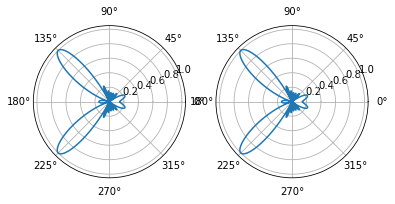

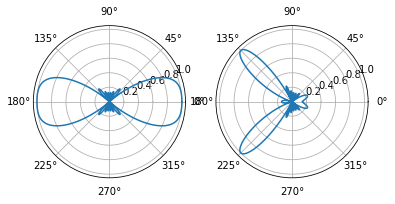

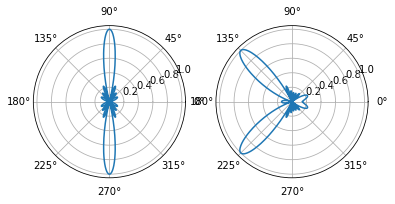

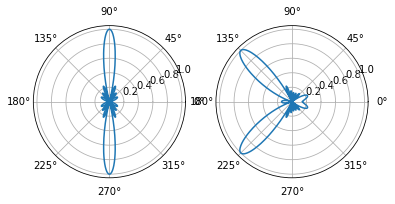

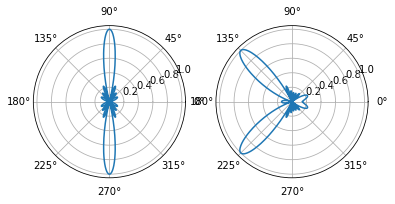

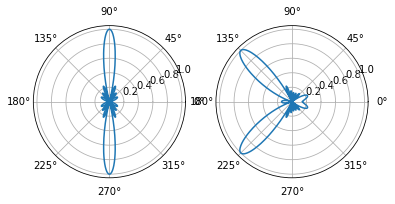

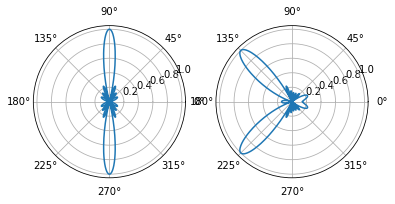

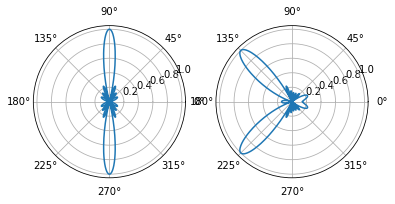

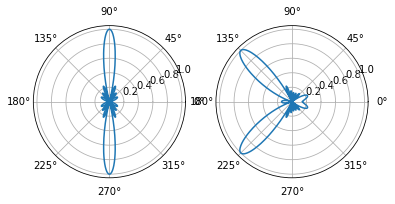

In [11]:
from Source.misc_fun.utils import plotbeam

print(tx_dirs)
print(rx_dirs)
for tx_ang, rx_ang in zip(tx_dirs, rx_dirs):
    tx_theta, tx_gr = plotbeam(tx_ang, em.env.N_tx)
    rx_theta, rx_gr = plotbeam(rx_ang, em.env.N_rx)
    ax1 = plt.subplot(122, projection='polar')
    ax1.plot(tx_theta, tx_gr)

    ax2 = plt.subplot(121, projection='polar')
    ax2.plot(rx_theta, rx_gr)

    plt.show()




## Display all exhaustive rate measurements from env

In [12]:
tx_locs = [np.array([[x, y, 0]]) for x in em.env.rx_xcov for y in em.env.rx_ycov]
verts = All_Exhaustive_RateMeas(tx_locs, 8, 8)

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

fig = plt.figure()
ax = fig.gca(projection='3d')
poly = PolyCollection(verts[:4], facecolors=['r', 'g', 'b', 'y'], alpha=0.6)
print(len(verts))
print(verts[0:2])
#print(np.array(tx_locs[:4]))
ax.add_collection3d(poly, zs=np.arange(1,5), zdir='y')

ax.set_xlabel('X (beam pairs)')
ax.set_ylabel('Y (tx_locs)')
ax.set_zlabel('Z (data rates)')
ax.set_xlim(0, 10)
ax.set_ylim(1, 5)
ax.set_zlim(10, 30)

plt.show()

In [13]:
#Find the best exhaustive beam for every location, tx_ndx in rx coverage area
def Find_Exh_LocBeams(verts, N_tx, N_rx):
    best_exhbeam_indices = []
    best_exh_rates =[]
    beam_ndx_loc_rates = []
    for loc_ndx in range(len(verts)):
        beam_ndx_rates = []
        for ndx in range(len(verts[loc_ndx])):
            tx_ndx = int((verts[loc_ndx][ndx][0]-1) / N_tx)
            rx_ndx = (verts[loc_ndx][ndx][0]-1) % N_rx
            beam_ndx_rates.append([tx_ndx, rx_ndx, verts[loc_ndx][ndx][1]])
        beam_ndx_loc_rates.append(beam_ndx_rates)

    #print(beam_ndx_rates)
    for tx_ndx in range(N_tx):

        for loc_ndx  in range(len(beam_ndx_loc_rates)):
            best_rate = 0.0
            best_rx_ndx = 0
            for ndx in range(len(beam_ndx_loc_rates[loc_ndx])):
                if (beam_ndx_loc_rates[loc_ndx][ndx][0]== tx_ndx) and (beam_ndx_loc_rates[loc_ndx][ndx][2] > best_rate):
                    best_rate = beam_ndx_loc_rates[loc_ndx][ndx][2]
                    best_rx_ndx = beam_ndx_loc_rates[loc_ndx][ndx][1]
            #bdir_ndx, rate = max(verts[loc_ndx], key= lambda x : x[1])
            best_exhbeam_indices.append([tx_ndx, best_rx_ndx])
            best_exh_rates.append(best_rate)
            
    return best_exhbeam_indices, best_exh_rates, beam_ndx_loc_rates


In [14]:
best_exhbeam_indices, best_exh_rates, beam_ndx_loc_rates = Find_Exh_LocBeams(verts, em.env.N_tx, em.env.N_rx)
print(len(best_exhbeam_indices))
print(len(best_exh_rates))
#print(beam_ndx_loc_rates[1])

16
16


## Test DQN agent on every RX coverage BS location

In [15]:
#Find the best DQN beam for every location, tx_ndx in rx coverage area
policy_net.load_state_dict(torch.load('checkpoint.pth'))


def Find_DQN_LocBeams(tx_locs, em, sc):
    best_dqn_loc_rxbeams = []
    best_dqnbeam_loc_indices = []
    best_dqn_loc_rates =[]
    best_dqn_loc_tsteps = []
    best_exh_loc_rates =[]
    best_exh_loc_rxbeams = []
    
    for loc in tx_locs:
        if (np.all(loc == [0, 0, 0])):
            loc = np.array([[40, 40, 0]])

        loc_dqn_rxbeams = []
        loc_dqnbeam_indices = []
        loc_dqn_rates =[]
        loc_dqn_tsteps = []
        loc_exh_rxbeams = []

        for bdir_ndx in range(em.env.N_tx):
            obs = em.test_reset(loc, bdir_ndx, sc)
            test_ep_rwds=[]
            tx_dirs=[]
            rx_dirs = []
            data_rates = []
            test_obs = []
            policy_net.eval()

            step = 0
            score = 0
            done = False
            while True:
                #test_obs.append(obs.cpu().data.numpy())
                action = policy_net(obs).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
                tx_dirs.append(em.env.tx_bdir)
                rx_dirs.append(em.env.rx_bdir)
                data_rates.append(em.env.rate)
                if done:
                    rate = data_rates[-1]
                    tsteps = len(data_rates)-1
                    rbdir_ndx = list(em.env.BeamSet).index(rx_dirs[-1])

                    #loc_dqn_rxbeams.append(rx_dirs[-1])
                    #loc_dqnbeam_indices.append(rbdir_ndx)
                    #loc_dqn_rates.append(rate)
                    #loc_dqn_tsteps.append(tsteps)
                    break
                next_obs, reward, done, _ = em.step(action)
                step+=1
                test_ep_rwds.append(reward.item())
                obs = next_obs

            best_dqn_loc_rxbeams.append(rx_dirs[-1])
            best_dqnbeam_loc_indices.append([bdir_ndx, loc_dqnbeam_indices])
            best_dqn_loc_rates.append(rate)
            best_dqn_loc_tsteps.append(tsteps)
            best_exh_loc_rates.append(em.env.get_exh_rate()[0])
            best_exh_loc_rxbeams.append(em.env.get_exh_rate()[1])
    return best_dqn_loc_rxbeams, best_dqnbeam_loc_indices, best_dqn_loc_rates, best_dqn_loc_tsteps, best_exh_loc_rates, best_exh_loc_rxbeams


In [16]:
tx_locs = [np.array([[x, y, 0]]) for x in em.env.rx_xcov for y in em.env.rx_ycov]
sc = em.env.sc_xyz#np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0]])
best_dqn_loc_rxbeams, best_dqnbeam_loc_indices, best_dqn_loc_rates, best_dqn_loc_tsteps, best_exh_loc_rates, best_exh_loc_rxbeams = Find_DQN_LocBeams(tx_locs, em, sc)

print(best_dqn_loc_rates[0])
print(best_dqn_loc_rxbeams[0])
print(len(best_dqnbeam_loc_indices))
print(len(best_exh_loc_rates))

27.804943118559127
3.141592653589793
16
16


16
16


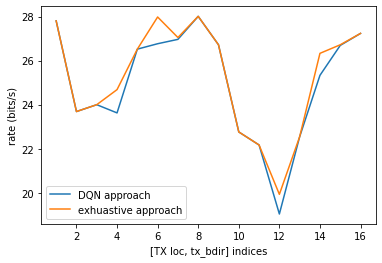

In [17]:
fig = plt.figure()
print(len(best_dqn_loc_rates))
print(len(best_exh_rates))

plt.plot(np.arange(1,len(best_dqn_loc_rates[:200])+1), best_dqn_loc_rates[:200], np.arange(1,len(best_exh_loc_rates[:200])+1), best_exh_loc_rates[:200])
plt.legend(['DQN approach', 'exhuastive approach'])
plt.xlabel('[TX loc, tx_bdir] indices')
plt.ylabel('rate (bits/s)')
plt.show()

[100. 150.]
16
[28.01007390164209, 27.235744686839745]
[28.01007390164209, 27.235744686839745]


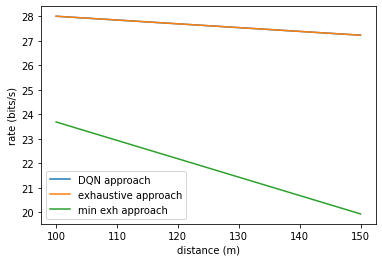

[array([[100,   0,   0]]), array([[150,   0,   0]])]
Exh Tx beam dirs:  [180.0, 180.0]
Exh Rx beam dirs:  [180.0, 180.0]
DQN TX beam dirs:  [180.0, 180.0]
DQN RX beam dirs:  [180.0, 180.0]


In [18]:
#exhaustive rate measurements with increasing TX distance from RX
sel_tx_xlocs = np.array([100,150])#np.array([50, 100, 150, 200, 250, 300, 400]) 
sel_tx_ylocs = np.array([0,0])#np.array([0, 0, 0, 0, 0, 0, 0])
sel_tx_locs = [np.array([[x, y, 0]]) for x, y in zip(sel_tx_xlocs, sel_tx_ylocs)]

sel_verts = All_Exhaustive_RateMeas(sel_tx_locs, 8, 8)
#print(sel_verts)
best_exhbeam_indices, best_exh_rates, beam_ndx_loc_rates= Find_Exh_LocBeams(sel_verts, 8, 8)

best_dqn_loc_rxbeams, best_dqnbeam_loc_indices, best_dqn_loc_rates, best_dqn_loc_tsteps, best_exh_loc_rates, best_exh_loc_rxbeams = Find_DQN_LocBeams(sel_tx_locs, em, sc)

sel_dist = np.array([np.sqrt(x**2+y**2) for x,y in zip(sel_tx_xlocs, sel_tx_ylocs)])
print(sel_dist)
print(len(best_dqn_loc_rates))

#select tx_ndx=3 related data rates for all sel_tx_locs
dqn_rates = []
exh_rates = []
min_exh_rates = []
exh_rxbeams = []
exh_txbeams = []
dqn_rxbeams = []
dqn_txbeams = []
sel_tx_ndx=1
for ndx in range(0, len(best_dqn_loc_rates), 8):
    dqn_rates.append(max(best_dqn_loc_rates[ndx:ndx+8]))
    best_txndx = best_dqn_loc_rates[ndx:ndx+8].index(max(best_dqn_loc_rates[ndx:ndx+8]))
    dqn_rxbeams.append(best_dqn_loc_rxbeams[ndx+best_txndx]*(180/np.pi))
    dqn_txbeams.append(em.env.BeamSet[best_txndx]*(180/np.pi))
    
    exh_rates.append(max(best_exh_loc_rates[ndx:ndx+8]))

    best_txndx = best_exh_loc_rates[ndx:ndx+8].index(max(best_exh_loc_rates[ndx:ndx+8]))
    exh_rxndx = best_exh_loc_rxbeams[ndx+best_txndx]
    exh_rxbeams.append(em.env.BeamSet[exh_rxndx]*(180/np.pi))
    
    exh_txbeams.append(em.env.BeamSet[best_txndx]*(180/np.pi))
    min_exh_rates.append(min(best_exh_loc_rates[ndx:ndx+8]))
print(dqn_rates)
print(exh_rates)

fig = plt.figure()
plt.plot(sel_dist, dqn_rates, sel_dist, exh_rates, sel_dist, min_exh_rates)
plt.legend(['DQN approach', 'exhaustive approach', 'min exh approach'])
plt.xlabel('distance (m)')
plt.ylabel('rate (bits/s)')

plt.show()

print(sel_tx_locs)
print("Exh Tx beam dirs: ", exh_txbeams)
print("Exh Rx beam dirs: ", exh_rxbeams)
print("DQN TX beam dirs: ", dqn_txbeams)
print("DQN RX beam dirs: ", dqn_rxbeams)

[[150   0   0]]
tensor([[0.0079, 0.8750, 0.3000, 0.0000]], device='cuda:0')
tstep:1, obs:[[0.00790077 0.875      0.3        0.        ]], action:tensor([7]), next_obs:[[0.04037655 0.875      0.3        0.        ]], rwd:1.0, donetensor([False], device='cuda:0')
tstep:2, obs:[[0.04037655 0.875      0.3        0.        ]], action:tensor([7]), next_obs:[[0.04037655 0.875      0.3        0.        ]], rwd:0.0, donetensor([False], device='cuda:0')
tstep:3, obs:[[0.04037655 0.875      0.3        0.        ]], action:tensor([7]), next_obs:[[0.04037655 0.875      0.3        0.        ]], rwd:0.0, donetensor([False], device='cuda:0')
tstep:4, obs:[[0.04037655 0.875      0.3        0.        ]], action:tensor([7]), next_obs:[[0.04037655 0.875      0.3        0.        ]], rwd:0.0, donetensor([False], device='cuda:0')
tstep:5, obs:[[0.04037655 0.875      0.3        0.        ]], action:tensor([7]), next_obs:[[0.04037655 0.875      0.3        0.        ]], rwd:0.0, donetensor([False], device='cud

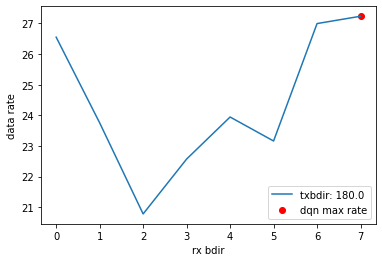

In [155]:
#exhaustive and dqn rate measurements for a given  TX_loc, TX_dir
policy_net.load_state_dict(torch.load('checkpoint.pth'))
sel_tx_xlocs = np.array([100,150])#np.array([50, 100, 150, 200, 250, 300, 400]) 
sel_tx_ylocs = np.array([0,0])#np.array([0, 0, 0, 0, 0, 0, 0])
sel_tx_locs = [np.array([[x, y, 0]]) for x, y in zip(sel_tx_xlocs, sel_tx_ylocs)]

print(sel_tx_locs[1])
tbdir_ndx = 7
sc = em.env.sc_xyz
obs = em.test_reset(sel_tx_locs[1], tbdir_ndx, sc)
print(obs)
policy_net.eval()

tx_dirs=[]
rx_dirs=[]
data_rates=[]
test_ep_rwds=[]
rbdir_indices = []
step=0
done = False
while True:
    action = policy_net(obs).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
    tx_dirs.append(em.env.tx_bdir)
    rx_dirs.append(em.env.rx_bdir)
    data_rates.append(em.env.rate)
    rbdir_ndx = list(em.env.BeamSet).index(em.env.rx_bdir)
    rbdir_indices.append(rbdir_ndx)
    if done:
        rate = data_rates[-1]
        tsteps = len(data_rates)-1
        

        break
    next_obs, reward, done, _ = em.step(action)
    step+=1
    print("tstep:{0}, obs:{1}, action:{2}, next_obs:{3}, rwd:{4}, done{5}".format(step, obs.cpu().data.numpy(), action.cpu().data, next_obs.cpu().data.numpy(), reward.item(), done))
    test_ep_rwds.append(reward.item())
    obs=next_obs

print("TX-loc: ", em.env.tx_loc)
print("tx_dir: ", [x*180/np.pi for x in tx_dirs])
print("rx_dirs: ", [x*180/np.pi for x in rx_dirs])
print("rbdir_indices: ", rbdir_indices)
print("data rates: ", data_rates)
print("rewards: ", test_ep_rwds)

best_exhrate, best_action_ndx, best_rssi_val= em.env.get_exh_rate()
exh_rssivalues, exh_ratevalues = em.env.meas_rate()
print("Exh rates for TX_loc: {0}, TXdir: {1}- ".format(em.env.tx_loc, em.env.tx_bdir*180/np.pi))
print(exh_ratevalues)
print("best exh_rate: {0}, best rssi_val: {1}, best action_ndx: {2}".format(best_exhrate, best_rssi_val, best_action_ndx))

#dqn_rates = np.zeros(8)
#for i 
fig = plt.figure()
plt.plot(exh_ratevalues)
plt.xlabel("rx bdir")
plt.ylabel("data rate")
plt.scatter([rbdir_indices[-1]], [data_rates[-1]], color='red')
plt.legend(["txbdir: {}".format(em.env.tx_bdir*180/np.pi), "dqn max rate"])

plt.show()

In [20]:
0.875*8

7.0

In [21]:
list(em.env.BeamSet).index(157.5*np.pi/180)

6

In [22]:
print(em.env.ch_model)
print(em.env.sc_xyz)

uma-nlos
[[  0 100   0]
 [ 10  50   0]
 [ 40  60   0]
 [ 70  80   0]
 [100  50   0]
 [ 80  85   0]
 [ 20  30   0]
 [ 10  40   0]
 [ 80  20   0]]


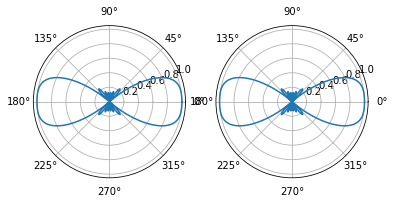

In [23]:
from Source.misc_fun.utils import plotbeam

tx_theta, tx_gr = plotbeam(exh_txbeams[0]*(np.pi/180), em.env.N_tx)
rx_theta, rx_gr = plotbeam(exh_rxbeams[0]*(np.pi/180), em.env.N_rx)
ax1 = plt.subplot(122, projection='polar')
ax1.plot(tx_theta, tx_gr)

ax2 = plt.subplot(121, projection='polar')
ax2.plot(rx_theta, rx_gr)

plt.show()

